In [43]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from Plot_XZ import *
from PCA import *

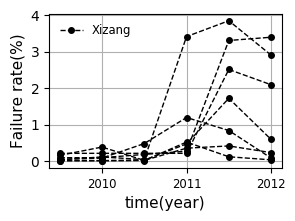

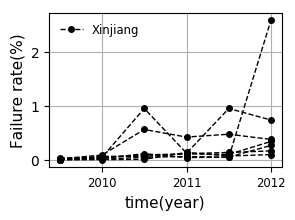

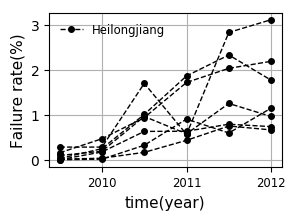

In [52]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])

# #特征因素分析
elec_tem = elec_data.Tem.values + SNR[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
# data_cs_year[42:45] = 12
# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# elec_Pca2 = np.vstack((elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
# elec_Pca_char3 = elec_Pca1[:, 2] # 降维特征2
# print(elec_Pca_char1)
elec_data.Fault.values[53] =2000
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)
# elec_faults[25] = 3
# elec_faults[39] = 5
# elec_faults[53] = 3.8
# print(elec_faults)
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*6:(i+1)*6] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*6:(i+1)*6] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*6:(i+1)*6] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*6:(i+1)*6] for i in np.arange(21)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_Pca_char1))
xs_char2 = shared(np.asarray(elec_Pca_char2))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(data_cs_year))
Num_shared = shared(np.asarray(companyABC))
# 画图
Plot_XZ(elec_year2, elec_faults2, Savefig)

def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

In [3]:
# 建模，模型
with pm.Model() as model_1:
    # define priors
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    #     sd_5 = pm.HalfNormal('sd_5', 0.5)

    mu_4 = pm.Normal('mu_4', mu=0, sd=100)
    sd_4 = pm.HalfCauchy('sd_4', 5)
    mu_3 = pm.Normal('mu_3', mu=0, sd=100)
    sd_3 = pm.HalfCauchy('sd_3', 5)
    mu_2 = pm.Normal('mu_2', mu=0, sd=100)
    sd_2 = pm.HalfCauchy('sd_2', 5)
    mu_1 = pm.Normal('mu_1', mu=0, sd=100)
    sd_1 = pm.HalfCauchy('sd_1', 5)

    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100, shape=companiesABC)
#     u = pm.Normal('u', 0, 0.01)

    beta_mu = pm.Deterministic('beta_mu', tt.exp(beta[Num_shared] + \
                                             (beta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 +\
                                              beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_year * xs_year)))

    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=ys_faults)  # 观测值
    trace_1 = pm.sample(3000,  init='jitter+adapt_diag' )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████████████████████████████████████████████▊| 3490/3500 [03:07<00:00, 18.56it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 320 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [03:08<00:00, 18.56it/s]


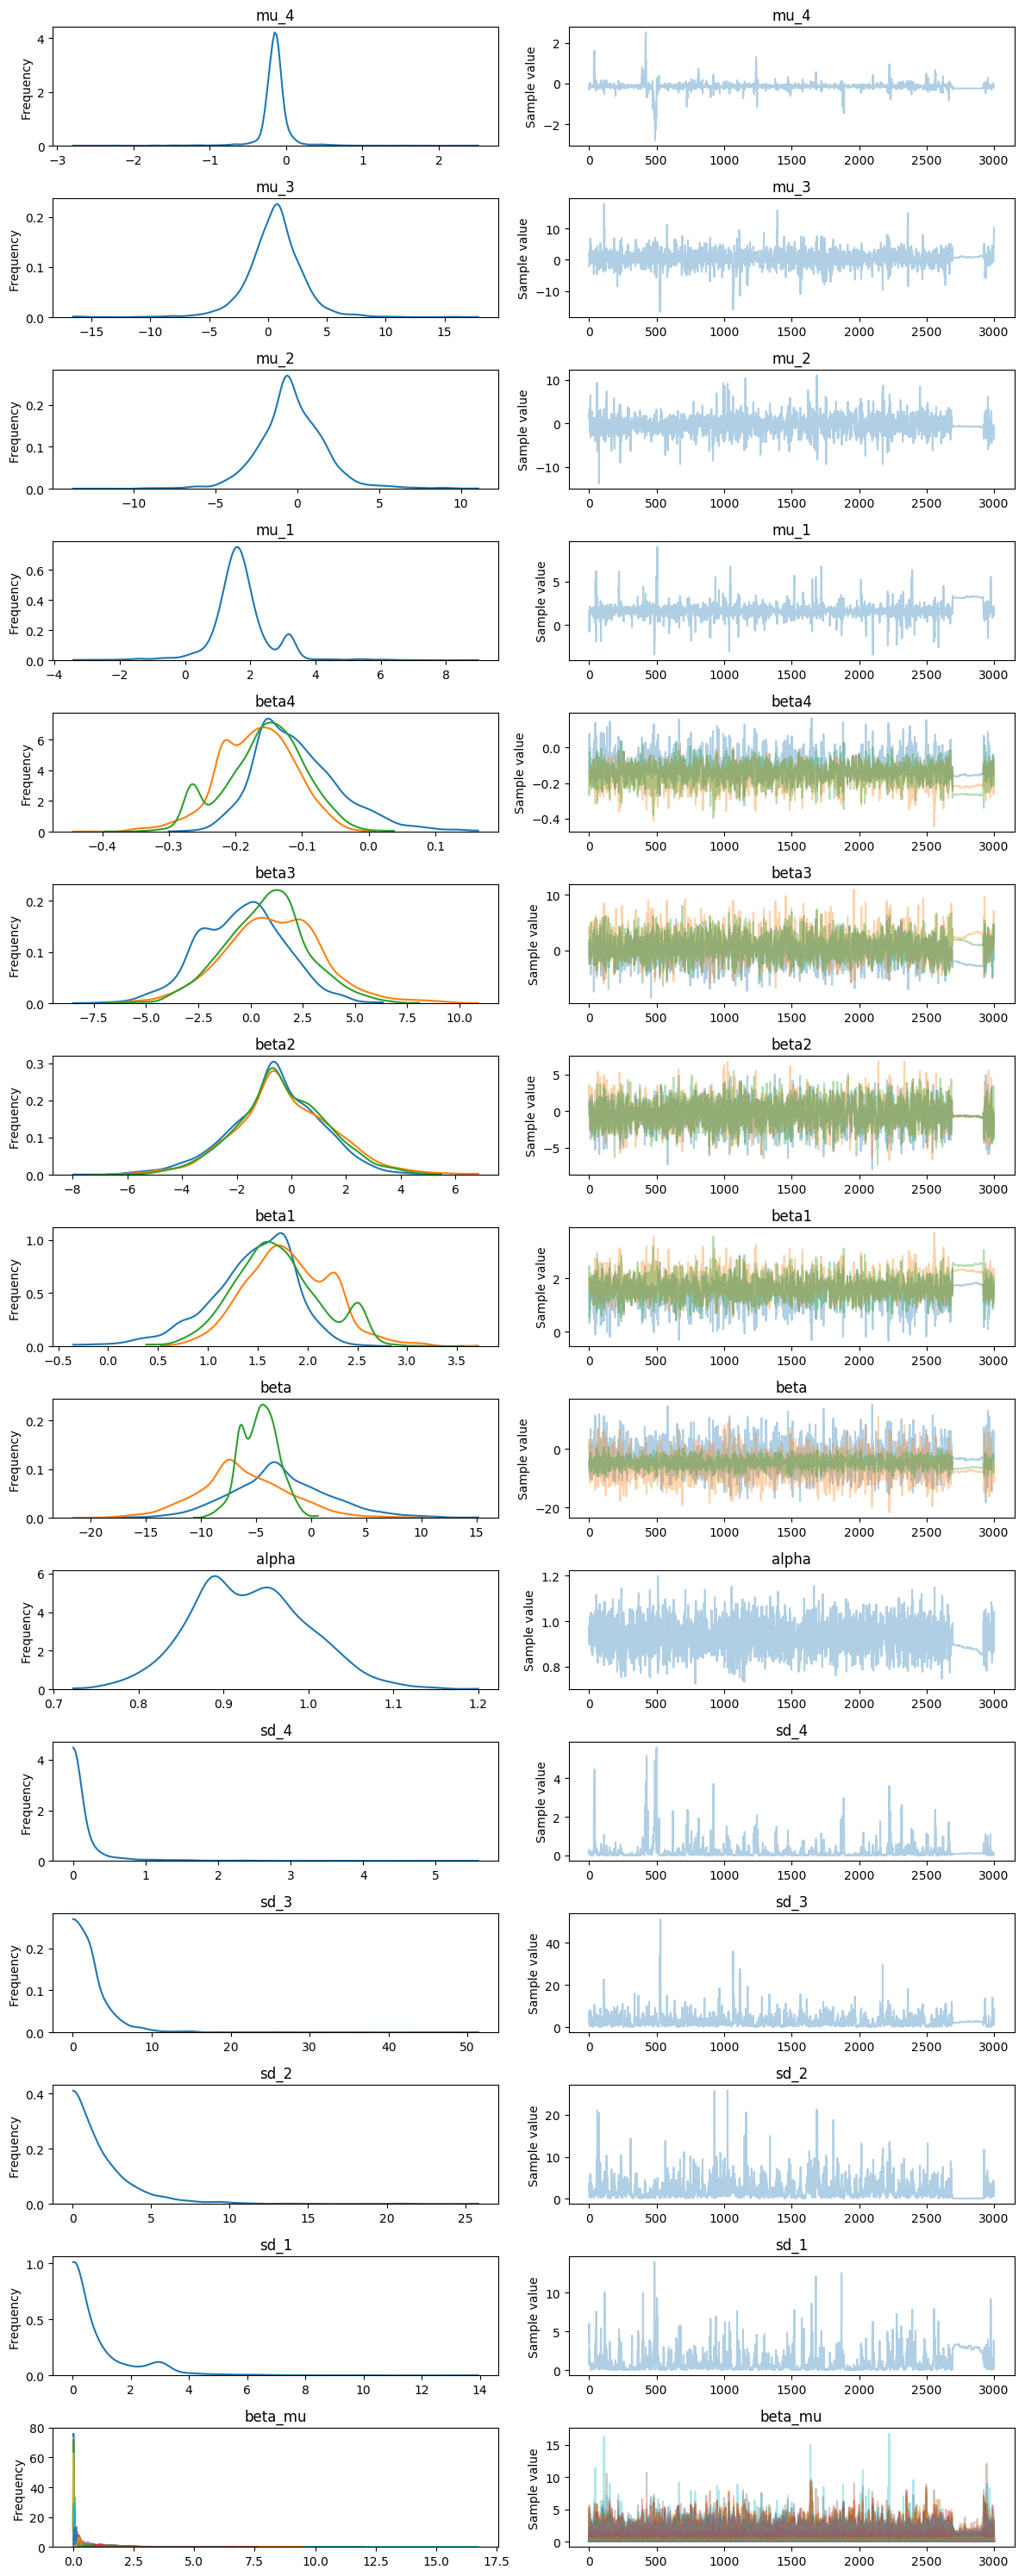

In [4]:
pm.traceplot(trace_1)
plt.show()

In [5]:
burnin = 2000
chain = trace_1[burnin:]
# get MAP estimate
varnames2 = ['beta', 'beta1', 'beta2', 'beta3','beta4']
tmp = pm.df_summary(chain, varnames2)
betaMAP = tmp['mean'][np.arange(companiesABC)]
beta1MAP = tmp['mean'][np.arange(companiesABC) + companiesABC]
beta2MAP = tmp['mean'][np.arange(companiesABC) + 2*companiesABC]
beta3MAP = tmp['mean'][np.arange(companiesABC) + 3*companiesABC]
beta4MAP = tmp['mean'][np.arange(companiesABC) + 4*companiesABC]
# uMAP = tmp['mean'][4*companiesABC+1]
# am0MAP = tmp['mean'][4*companiesABC+2]
# am1MAP = tmp['mean'][4*companiesABC+3]
# print(am0MAP)
# print(beta1MAP)
# print(tmp)
# print(beta2MAP)
# print(beta3MAP)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
D:\Softwares\Python\Python_Anaconda\lib\site-packages\seaborn\categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


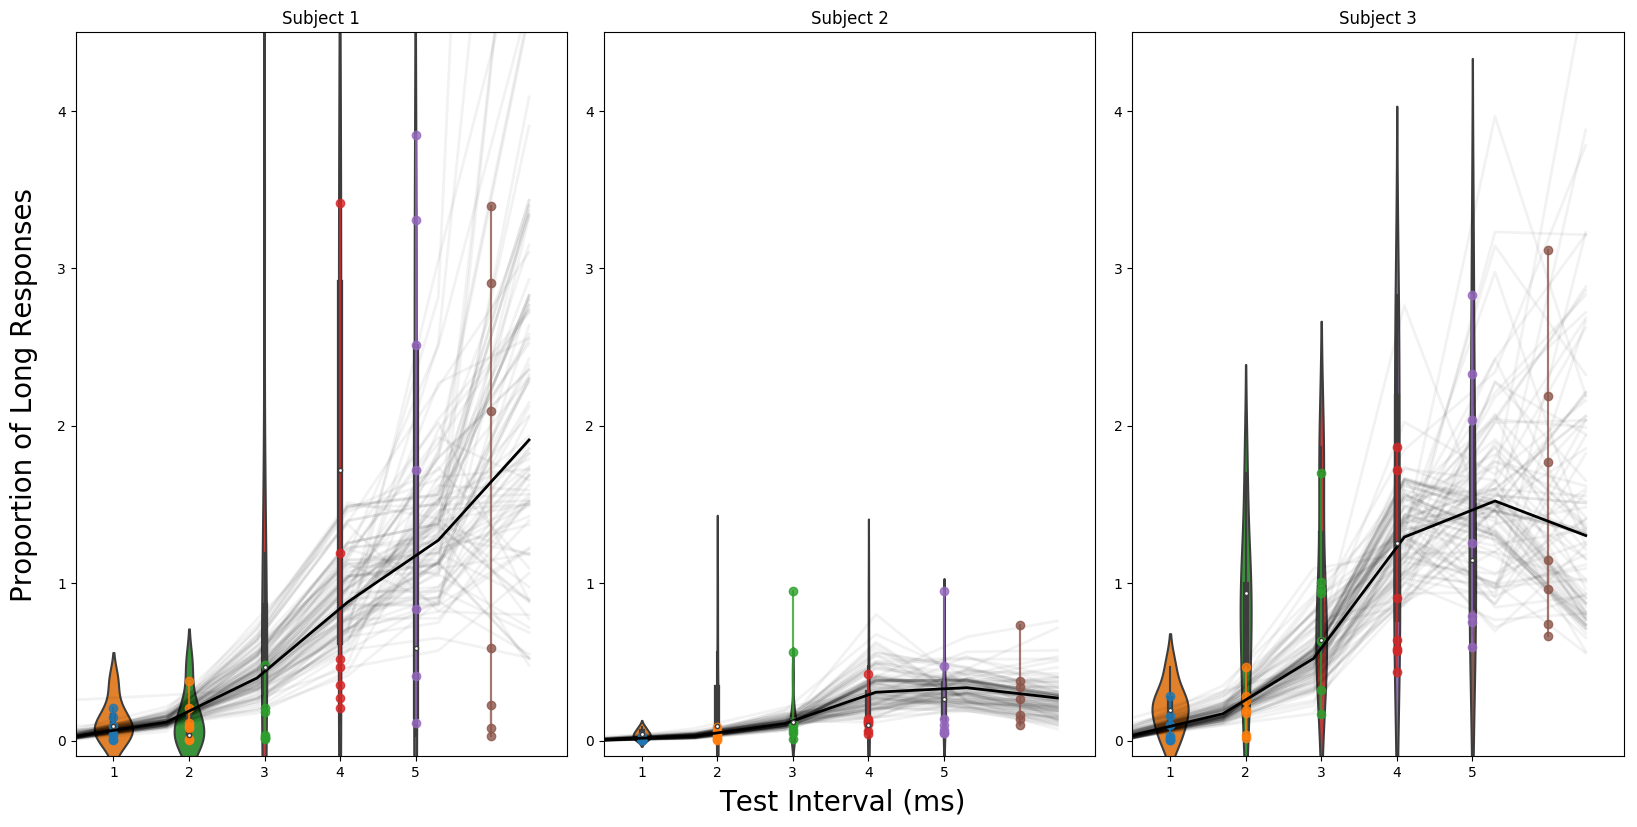

In [6]:
# 模型拟合效果图
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    

    xl = np.linspace(0.5, 6.5, 6)
    yl = np.exp(betaMAP[ip] + (beta1MAP[ip]*xl + beta2MAP[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP[ip]*xl*xl))
    
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_1[ips]
        yl2 = np.exp(param['beta'][ip] + (param['beta1'][ip] * (xl) + \
                     param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
    ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
    plt.plot(xl, yl, 'k', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

In [33]:
# 建模，加上含污染模型对比
with pm.Model() as model_2:
    # define priors
    b = 2
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    mu_4 = pm.Normal('mu_4', mu=0, sd=100)
    sd_4 = pm.HalfCauchy('sd_4', b)
    mu_3 = pm.Normal('mu_3', mu=0, sd=100)
    sd_3 = pm.HalfCauchy('sd_3', b)
    mu_2 = pm.Normal('mu_2', mu=0, sd=100)
    sd_2 = pm.HalfCauchy('sd_2', b)
    mu_1 = pm.Normal('mu_1', mu=0, sd=100)
    sd_1 = pm.HalfCauchy('sd_1', b)
    mu_0 = pm.Normal('mu_0', mu=0, sd=100)
    sd_0 = pm.HalfCauchy('sd_0', b)
#     sd_4 = pm.Uniform('sd_4', lower=0.1, upper=100)
#     sd_3 = pm.Uniform('sd_3', lower=-10, upper=10)
#     sd_2 = pm.Uniform('sd_2', lower=0.1, upper=100)
#     sd_1 = pm.Uniform('sd_1', lower=0.1, upper=100)
    
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', mu_0, sd_0, shape=companiesABC)
#     u = pm.Normal('u', 0, 0.01)

    liner = pm.Deterministic('liner', tt.exp(beta[ip] + \
                                             (beta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 +\
                                              beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_year * xs_year)))

    # latent model for contamination
#     upper = pm.HalfCauchy('upper', 10)
    sigma_p = pm.HalfCauchy('sigma_p', b)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)

    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(Num_shared.get_value()))
    
    zij_ = pm.theanof.tt_rng().uniform(size=companyABC.shape)
    zij = pm.Deterministic('zij', tt.lt(zij_, phii[Num_shared]))   

    beta_mu = pm.Deterministic('beta_mu', tt.switch(zij, liner, pi_ij))
    
    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=ys_faults)  # 观测值

import theano
with model_2:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace_2 = approx.sample(3000, include_transformed=True)
    elbos1 = -inference.hist

WARNING (theano.gof.cmodule): Removing key file C:\Users\qw\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.6.1-64\tmp1z6s5__s\key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file C:\Users\qw\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.6.1-64\tmp65ra_2vg\key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file C:\Users\qw\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.6.1-64\tmpapeb6c1n\key.pkl because the corresponding module is gone from the file system.
WARNING (theano.gof.cmodule): Removing key file C:\Users\qw\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-SP0-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.6.1-64\tmpd8co0aco\key.pkl because the correspondi

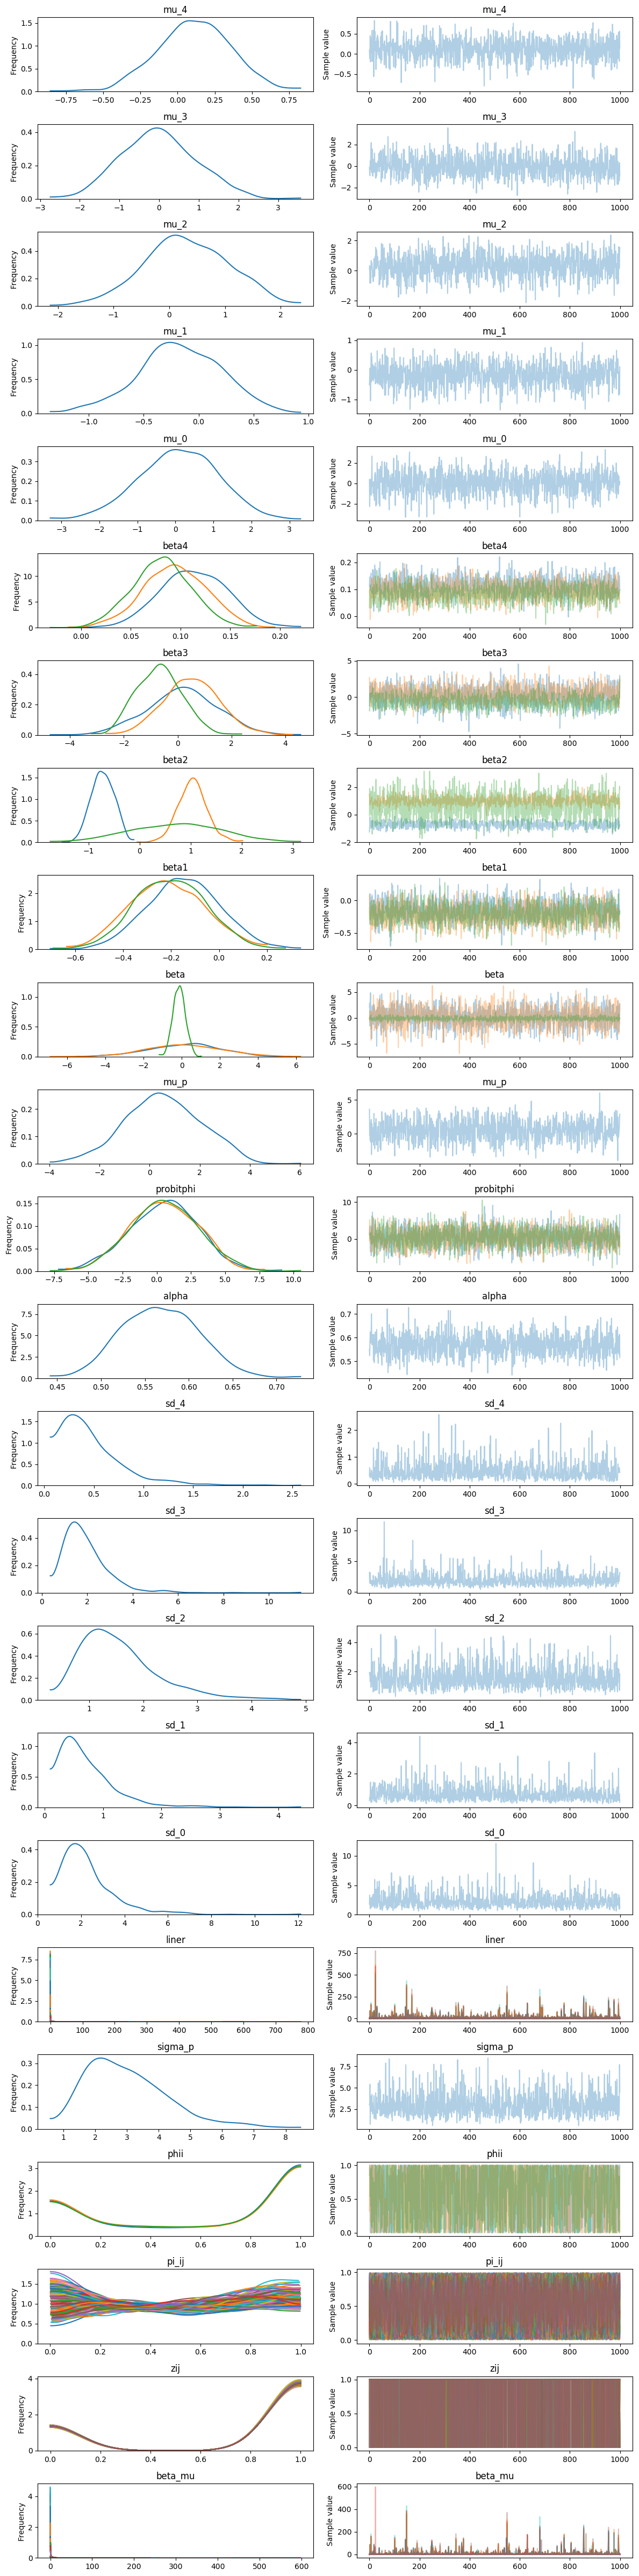

In [34]:
chain_2 = trace_2[2000:]
# varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
pm.traceplot(chain_2)
plt.show()

In [50]:
# njob = 1
# start = trace_2[0]
# start['zij'] = start['zij'].astype(int)
# stds = approx.bij.rmap(approx.std.eval())
# cov = model_2.dict_to_array(stds) ** 2
# 建模，加上含污染模型对比
with pm.Model() as model_2b:
    # define priors 
    b = 3
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    mu_4 = pm.Normal('mu_4', mu=0, sd=100)
    sd_4 = pm.HalfCauchy('sd_4', b)
    mu_3 = pm.Normal('mu_3', mu=0, sd=100)
    sd_3 = pm.HalfCauchy('sd_3', b)
    mu_2 = pm.Normal('mu_2', mu=0, sd=100)
    sd_2 = pm.HalfCauchy('sd_2', b)
    mu_1 = pm.Normal('mu_1', mu=0, sd=100)
    sd_1 = pm.HalfCauchy('sd_1', b)
    mu_0 = pm.Normal('mu_0', mu=0, sd=100)
    sd_0 = pm.HalfCauchy('sd_0', b)
#     sd_4 = pm.Uniform('sd_4', lower=0.1, upper=100)
#     sd_3 = pm.Uniform('sd_3', lower=-10, upper=10)
#     sd_2 = pm.Uniform('sd_2', lower=0.1, upper=100)
#     sd_1 = pm.Uniform('sd_1', lower=0.1, upper=100)
    
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', mu_0, sd_0, shape=companiesABC)
#     u = pm.Normal('u', 0, 0.01)

    liner = pm.Deterministic('liner', tt.exp(beta[ip] + \
                                             (beta1[Num_shared] * xs_year + beta2[Num_shared] * xs_char1 +\
                                              beta3[Num_shared] * xs_char2 + beta4[Num_shared] * xs_year * xs_year)))


    phic = pm.Uniform('phic', lower=0, upper=1, testval=.3)
    zck = pm.Bernoulli('zck', p=phic, shape=companyABC.shape)
    #     zij_ = pm.theanof.tt_rng().uniform(size=xij.shape)
    #     zij = pm.Deterministic('zij', tt.lt(zij_, phii[sbjid]))
    line = tt.constant(np.ones((len(companyABC))) * .5)
    beta_mu = pm.Deterministic('beta_mu', tt.squeeze(tt.switch(tt.eq(zck, 0), liner, line))) 
    # latent model for contamination
#     pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(Num_shared.get_value()))
#     sigma_p = pm.HalfCauchy('sigma_p', b)
#     mu_p = pm.Normal('mu_p', mu=0, tau=.001)
#     probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
#     phii = pm.Deterministic('phii', Phi(probitphi))      
#     zij = pm.Bernoulli('zij', p=phii[Num_shared], shape=len(Num_shared.get_value()))
#     zij = pm.Bernoulli('zij', p=phii[Num_shared], shape=len(Num_shared.get_value()))
#     beta_mu = pm.Deterministic('beta_mu', tt.switch(tt.eq(zij, 0), liner, pi_ij))
    
    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=ys_faults)  # 观测值
    
#     step1 = pm.Metropolis([zij])
    
    start = pm.find_MAP()
#     step = pm.NUTS(scaling=cov, is_cov=True)
#     trace_2b = pm.sample(3000, step=[step,step1], start=start, njobs=1, turn =500)
    trace_2b = pm.sample(3000,  init='advi+adapt_diag', start=start)

logp = 50.726, ||grad|| = 433.21: 100%|███████████████████████████████████████████| 2399/2399 [00:02<00:00, 926.30it/s]
Assigned NUTS to alpha_log__
Assigned NUTS to mu_4
Assigned NUTS to sd_4_log__
Assigned NUTS to mu_3
Assigned NUTS to sd_3_log__
Assigned NUTS to mu_2
Assigned NUTS to sd_2_log__
Assigned NUTS to mu_1
Assigned NUTS to sd_1_log__
Assigned NUTS to mu_0
Assigned NUTS to sd_0_log__
Assigned NUTS to beta4
Assigned NUTS to beta3
Assigned NUTS to beta2
Assigned NUTS to beta1
Assigned NUTS to beta
Assigned NUTS to phic_interval__
Assigned BinaryGibbsMetropolis to zck
 12%|█████████▊                                                                     | 433/3500 [01:45<12:24,  4.12it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:429: UserWarning: Chain 0 contains only 0 samples.
  % (self._chain_id, n))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:431: UserWarning: Step size tuning was enabled thro

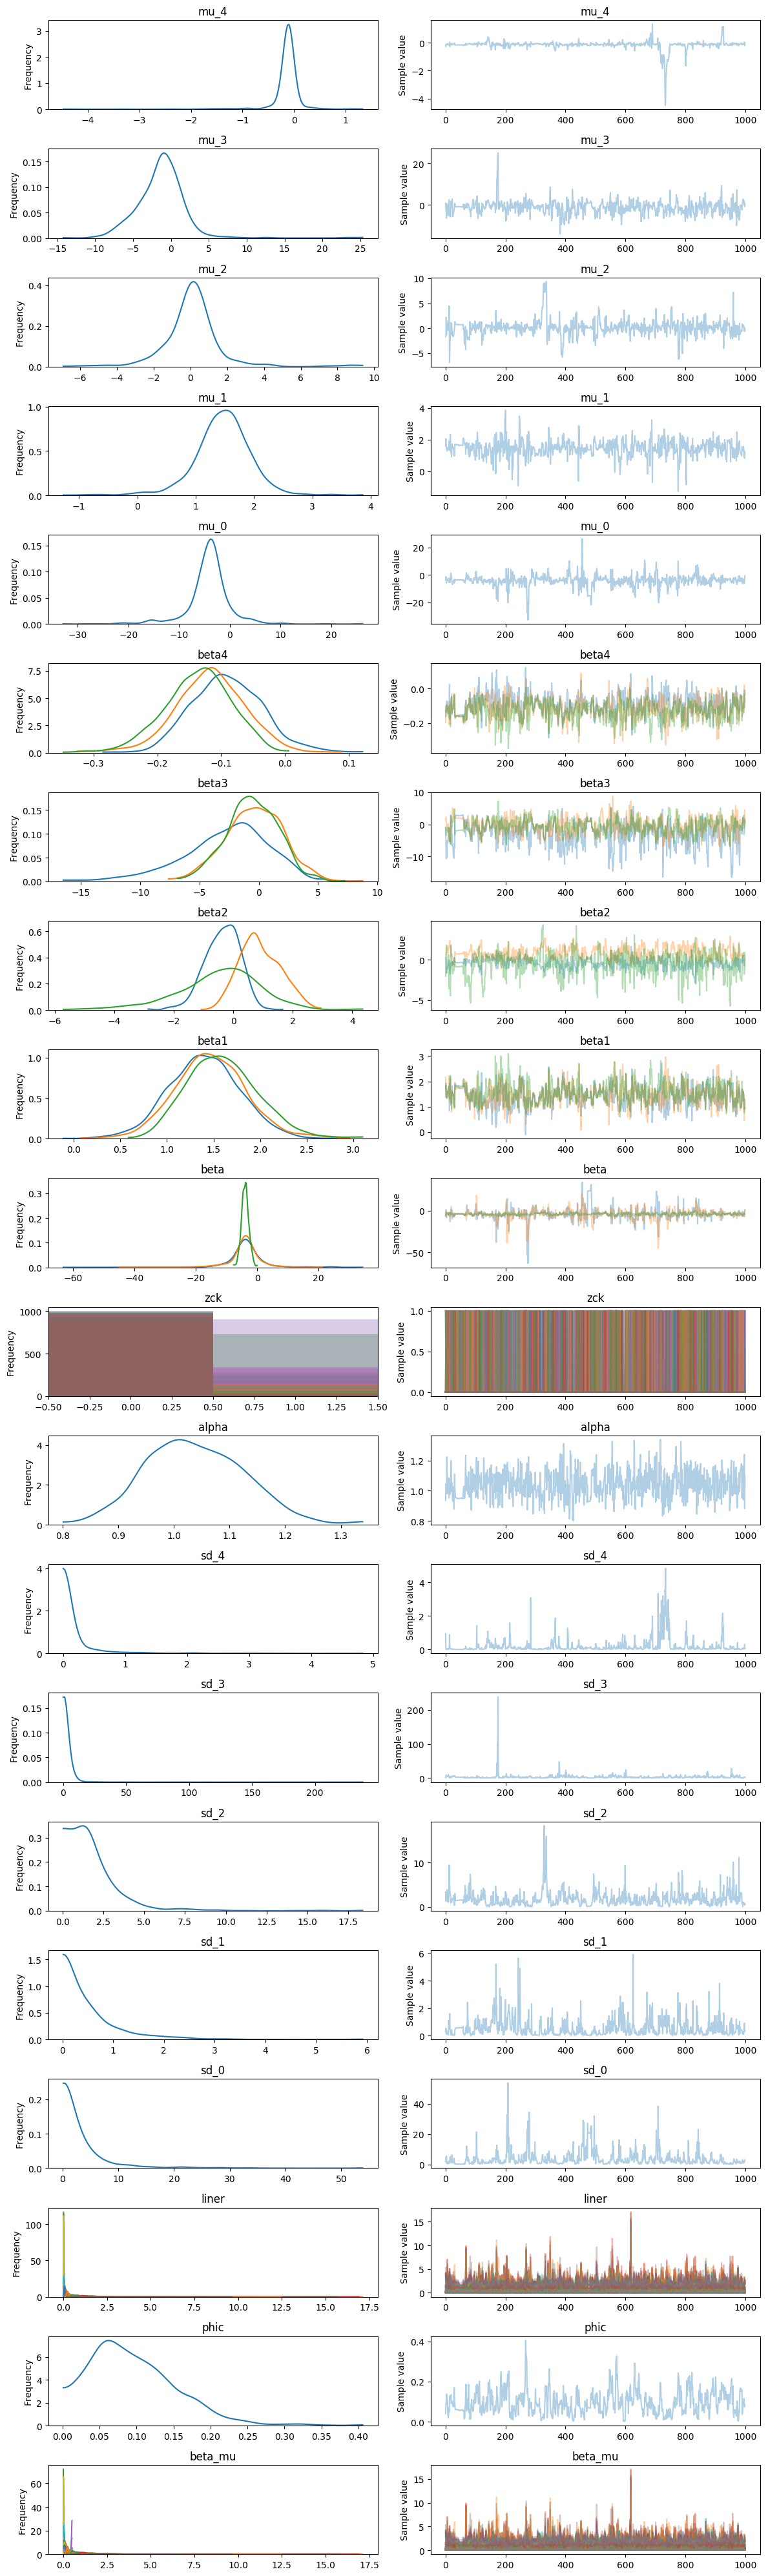

In [46]:
chain_2b = trace_2b[2000:]
# varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
pm.traceplot(chain_2b)
plt.show()

In [48]:
varnames2b = ['beta', 'beta1', 'beta2', 'beta3','beta4']
tmp2 = pm.df_summary(chain_2b, varnames2b)
betaMAP2 = tmp2['mean'][np.arange(companiesABC)]
beta1MAP2 = tmp2['mean'][np.arange(companiesABC) + companiesABC]
beta2MAP2 = tmp2['mean'][np.arange(companiesABC) + 2*companiesABC]
beta3MAP2 = tmp2['mean'][np.arange(companiesABC) + 3*companiesABC]
beta4MAP2 = tmp2['mean'][np.arange(companiesABC) + 4*companiesABC]
# uMAP2 = tmp2['mean'][4*companiesABC+1]
# am0MAP = tmp['mean'][4*companiesABC+2]
# am1MAP = tmp['mean'][4*companiesABC+3]
# print(am0MAP)
# print(beta1MAP)
# print(tmp)
# print(beta2MAP)
# print(beta3MAP)

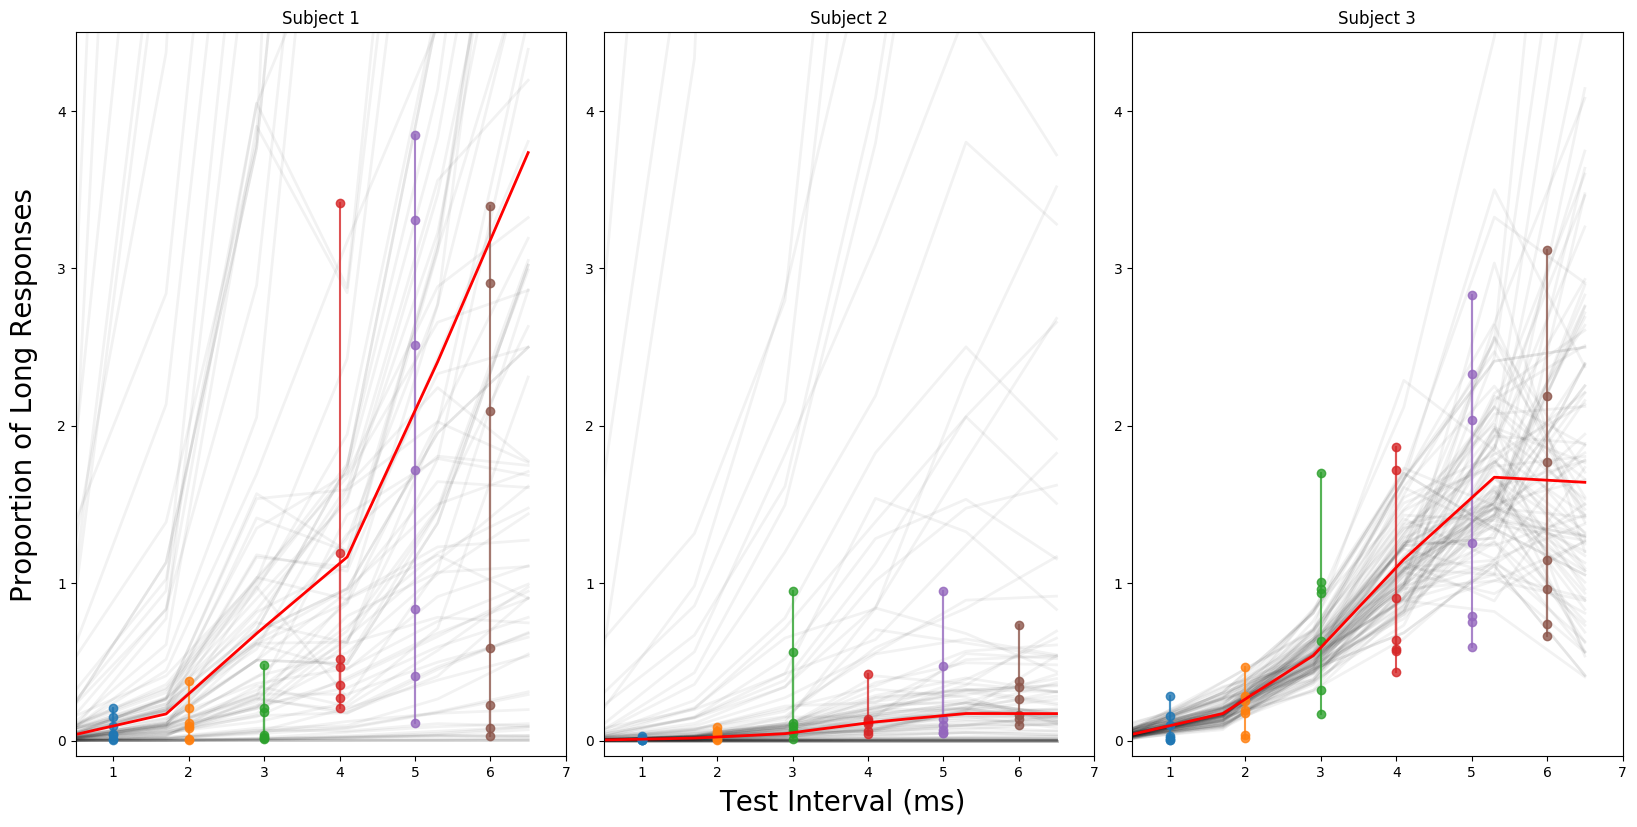

In [49]:
# 模型拟合效果图
# ppc_2b = pm.sample_ppc(chain_2b, 500, model=model_2b)
# # sig0 = pm.hpd(ppc['Observed'], alpha=0.5)
# sig_2b_95 = pm.hpd(ppc_2b['Observed'], alpha=0.05) 
# # print(sig0[0:42,0])


ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    

    xl = np.linspace(0.5, 6.5, 6)
#     yl = np.exp(betaMAP + (beta1MAP[ip]*xl + beta2MAP[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
#                 beta3MAP[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP[ip]*xl*xl))
    
    y2 = np.exp(betaMAP2[ip] + (beta1MAP2[ip]*xl + beta2MAP2[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP2[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP2[ip]*xl*xl))   
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_2b[ips]
        yl2 = np.exp(param['beta'][ip] + (param['beta1'][ip] * (xl) + \
                     param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
        
#     ax.fill_between(elec_year[ip*42:(ip*42+30)], sig_2b_95[:, 0][ip*42:(ip*42+30)], sig_2b_95[:, 1][ip*42:(ip*42+30)])
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
#     plt.plot(xl, yl, 'k--', linewidth=2)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

In [13]:
WAIC = pm.compare([trace_1, trace_2b], [model_1, model_2b], ic='WAIC')
print(WAIC)

    WAIC  pWAIC  dWAIC weight     SE    dSE warning
0 -27.96  11.54      0   0.98  39.66      0       1
1  19.51  28.59  47.47   0.02  37.71  13.19       1


In [14]:
# 应用偏最小二乘PLS来进行仿真
from sklearn.cross_decomposition import PLSRegression
X_PLSR = np.vstack((elec_year, elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
X_PLSR_XZ = X_PLSR[:42, :]
X_PLSR_XJ = X_PLSR[42:84, :]
X_PLSR_HLJ = X_PLSR[84:, :]
# X_PLSR_HLJ[:5, 0]=7
# print(X_PLSR_HLJ)
Y_PLSR = elec_faults
Y_PLSR_XZ = Y_PLSR[:42]
Y_PLSR_XJ = Y_PLSR[42:84]
Y_PLSR_HLJ = Y_PLSR[84:]
# print(Y_PLSR_XZ)


pls_XZ = PLSRegression(n_components=2)
pls_XZ.fit(X_PLSR_XZ, Y_PLSR_XZ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XZ = pls_XZ.predict(X_PLSR_XZ)
Y_PLSpred_XZ =  np.vstack((Y_PLSpred_XZ).T)[0]
# print(X_train_r)
# print(Y_PLSpred_XZ)

pls_XJ = PLSRegression(n_components=2)
pls_XJ.fit(X_PLSR_XJ, Y_PLSR_XJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XJ = pls_XJ.predict(X_PLSR_XJ)
Y_PLSpred_XJ =  np.vstack((Y_PLSpred_XJ).T)[0]
# print(X_train_r)
# print(Y_PLSpred_XJ)


pls_HLJ = PLSRegression(n_components=2)
pls_HLJ.fit(X_PLSR_HLJ, Y_PLSR_HLJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_HLJ, Y_PLSR_HLJ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_HLJ = pls_HLJ.predict(X_PLSR_HLJ)
Y_PLSpred_HLJ =  np.vstack((Y_PLSpred_HLJ).T)[0]
# print(Y_PLSpred_HLJ)
# print(Y_train_r)

Y_PLSpred = np.vstack((Y_PLSpred_XZ, Y_PLSpred_XJ, Y_PLSpred_HLJ))# Pls预测值
Y_PLSpred_Target = np.vstack((Y_PLSR_XZ, Y_PLSR_XJ, Y_PLSR_HLJ)) # 目标值
# print(Y_PLSpred)
# print(Y_PLSpred)

aaa = pls_HLJ.get_params(deep=True) # 获取参数
print(aaa)

{'copy': True, 'max_iter': 500, 'n_components': 2, 'scale': True, 'tol': 1e-06}


In [15]:
# 计算均方误差
def Rmse(predictions, targets):
    return  np.sqrt(np.mean((predictions - targets)**2))

rmse = {}
for ip in np.arange(3):
    rmse[ip] = Rmse(Y_PLSpred_Target[ip, :], Y_PLSpred[ip, :])

print('PLSR: ',rmse)


y22 = np.zeros((21, 6))
y22_1 = np.zeros((21, 6))
for ip in np.arange(3):
    for i in np.arange(7):
            y22[(ip*6 + i), :] = np.exp(betaMAP2[ip]  + (beta1MAP2[ip]*xl + beta2MAP2[ip]*elec_Pca_char1[(ip*42+i*6):(ip*42+6*(i+1))] + \
                        beta3MAP2[ip]*elec_Pca_char2[(ip*42+i*6):(ip*42+6*(i+1))] + beta4MAP2[ip]*xl*xl)) 
            y22_1[(ip*6 + i), :] = np.exp(betaMAP[ip]  + (beta1MAP[ip]*xl + beta2MAP[ip]*elec_Pca_char1[(ip*42+i*6):(ip*42+6*(i+1))] + \
                        beta3MAP[ip]*elec_Pca_char2[(ip*42+i*6):(ip*42+6*(i+1))] + beta4MAP[ip]*xl*xl)) 

a,a1,a2 =  np.array([]),np.array([]),np.array([])
global b_faults
b_faults = Y_PLSpred
a_1,a1_1,a2_1 =  np.array([]),np.array([]),np.array([])
global b_faults_1
b_faults_1 = Y_PLSpred

for i in np.arange(7):
    a = np.append(a, y22[i])
    a1 = np.append(a1, y22[i+7])
    a2 = np.append(a2, y22[i+14])
    
    a_1 = np.append(a_1, y22_1[i])
    a1_1 = np.append(a1_1, y22_1[i+7])
    a2_1 = np.append(a2_1, y22_1[i+14])
b_faults = np.vstack((a, a1, a2))
b_faults_1 = np.vstack((a_1, a1_1, a2_1))

rmse2 = {}
rmse2_1 = {}
elec_fa = np.array([elec_faults[i*42:(i+1)*42] for i in np.arange(3)])
# print(elec_fa)
# 模型2 的均方误差值
 
for ip in np.arange(3):
    rmse2[ip] = Rmse(b_faults[ip, :], elec_fa[ip, :])
    rmse2_1[ip] = Rmse(b_faults_1[ip, :], elec_fa[ip, :])
print('Model_1: ', rmse2_1)
print('Model2: ', rmse2)

PLSR:  {0: 0.97775628500701606, 1: 0.2170696503123262, 2: 0.60547737469815333}
Model_1:  {0: 1.1035905189834041, 1: 0.44756279621853934, 2: 0.98840630866599277}
Model2:  {0: 720.90608883450375, 1: 5.6864017598155705, 2: 1.068511705087853}


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3777.91it/s]


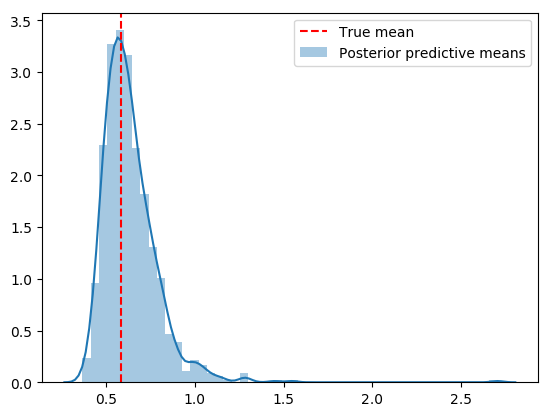

In [16]:
# 后验分析
ppc = pm.sample_ppc(trace_2b, samples=1000, model=model_2b)
yipred = ppc['Observed']
# plt.hist(yipred, normed=1, bins=80, alpha=.8, label='Posterior')
# plt.show()
plt.figure()
ax = sns.distplot(ppc['Observed'].mean(axis=1), label='Posterior predictive means') # axis=1以行方式计算
ax.axvline(elec_faults.mean(), color='r', ls='--', label='True mean')
ax.legend()
plt.show()

In [17]:
print(tmp)
print(tmp2)

              mean        sd  mc_error    hpd_2.5  hpd_97.5
beta__0  -3.099307  4.224295  0.193201 -11.696400  6.527332
beta__1  -6.418872  3.898993  0.183826 -13.865764  2.134465
beta__2  -4.949045  1.659814  0.107738  -7.318227 -1.341571
beta1__0  1.472811  0.416123  0.025852   0.644717  2.185272
beta1__1  1.891458  0.423876  0.029321   1.082192  2.564389
beta1__2  1.833136  0.495997  0.039475   1.014387  2.576286
beta2__0 -0.525250  1.585467  0.070572  -3.931755  2.897803
beta2__1 -0.333177  1.757618  0.080151  -3.324016  3.960329
beta2__2 -0.377978  1.598884  0.067551  -3.251405  3.361011
beta3__0 -0.720539  1.969464  0.120621  -4.027915  3.191876
beta3__1  1.327062  2.209996  0.119014  -3.473679  5.192872
beta3__2  0.856069  1.766188  0.085464  -3.120314  4.137283
beta4__0 -0.112887  0.061959  0.003831  -0.205801  0.024602
beta4__1 -0.177616  0.054166  0.003579  -0.266185 -0.063795
beta4__2 -0.173772  0.067255  0.005328  -0.267931 -0.056233
              mean        sd  mc_error  